In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

overwrite_figures = True

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.25e-3,0.25e-3,0.25e-3),
            matrix_dims = (256,256,128),
            baseline = (1500, 1000),
            seed = 5678,)

# water = tissue.Tissue(name='water', c=1500, rho=1000, sigma=40, scale=0.0001, label=0)
water = tissue.Tissue(name='water', c=1500, rho=1000, sigma=0, scale=0.0001, label=0)
t1 = tissue.Tissue(name='t1', c=1540, rho=1000, sigma=0, scale=0.0001, label=1)
t2 = tissue.Tissue(name='t2', c=1540, rho=1000, sigma=15, scale=0.0001, label=2)
t3 = tissue.Tissue(name='t3', c=1540, rho=1000, sigma=30, scale=0.0001, label=3)
t4 = tissue.Tissue(name='t4', c=1540, rho=1000, sigma=45, scale=0.0001, label=4)
t5 = tissue.Tissue(name='t5', c=1540, rho=1000, sigma=60, scale=0.0001, label=5)

pos = 0.008
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

# test_phantom.add_tissue_sphere((pos,-2*pos,0), 4, t5)
# test_phantom.add_tissue_sphere((pos,2*pos,0), 4, t5)

test_phantom.add_tissue_sphere((-pos,-2*pos,0), 4, t5)
test_phantom.add_tissue_sphere((-pos,-pos,0), 4, t4)
test_phantom.add_tissue_sphere((-pos,0,0), 4, t3)
test_phantom.add_tissue_sphere((-pos,pos,0), 4, t2)
test_phantom.add_tissue_sphere((-pos,2*pos,0), 4, t1)
test_phantom.add_tissue_sphere((pos,-2*pos,0), 8, t1)
test_phantom.add_tissue_sphere((pos,-pos,0), 8, t2)
test_phantom.add_tissue_sphere((pos,0,0), 8, t3)
test_phantom.add_tissue_sphere((pos,pos,0), 8, t4)
test_phantom.add_tissue_sphere((pos,2*pos,0), 8, t5)
test_phantom.add_tissue_sphere((3*pos,-2*pos,0), 12, t5)
test_phantom.add_tissue_sphere((3*pos,-pos,0), 12, t4)
test_phantom.add_tissue_sphere((3*pos,0,0), 12, t3)
test_phantom.add_tissue_sphere((3*pos,pos,0), 12, t2)
test_phantom.add_tissue_sphere((3*pos,2*pos,0), 12, t1)
    
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

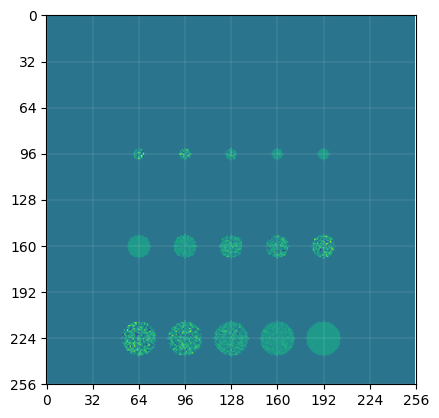

In [3]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])

plt.gca().set_xticks(np.linspace(0, test_phantom.matrix_dims[1],9))
plt.gca().set_yticks(np.linspace(0, test_phantom.matrix_dims[0],9))
plt.gca().grid(color='w', linestyle='-', linewidth=0.1)

In [4]:
import math

def fibonacci_sphere(samples=1000, maxphi=2*np.pi):
    coords = []
    angles = []
    phi = math.pi * (math.sqrt(5.) - 1.)
    if samples == 1:
        return np.array([[-1,0,0]]), np.array([[0,0,0]])
    for i in range(samples):
        x = -1 + (i / float(samples - 1)) * 2  * maxphi / (2 * np.pi)
        radius = math.sqrt(1 - x * x)
        theta = phi * i
        y = math.cos(theta) * radius
        z = math.sin(theta) * radius
        coords.append((x, y, z))
        angles.append((math.acos(x), -np.pi, theta % (np.pi * 2) - np.pi))
    return np.array(coords), np.array(angles)

def simple_cone(samples=1000, maxphi=2*np.pi):
    coords = []
    angles = []
    phi = math.pi * (math.sqrt(5.) - 1.)
    for i in range(samples):
        # x = -1 + (i / float(samples - 1)) * 2  * maxphi / (2 * np.pi)
        x = -1 + maxphi /  (np.pi)
        radius = math.sqrt(1 - x * x)
        theta = 2 * np.pi * i / samples
        y = math.cos(theta) * radius
        z = math.sin(theta) * radius
        coords.append((x, y, z))
        angles.append((math.acos(x), -np.pi, theta % (np.pi * 2) - np.pi))
    return np.array(coords), np.array(angles)

In [5]:
num_transducers = 4096
transducers = [transducer.Focused(max_frequency=0.5e6,
                                    elements = 1, 
                                    width = 2e-3,
                                    height =  2e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = (0,0),
                                    ray_num = (1,1),
                                    imaging_ndims = 3,
                                    focus_azimuth = float('inf'),
                                    focus_elevation = float('inf'),
                                    source_strength = 1e7,
                                    cycles = 1,
                                    transmit = i%21==0,
                                    ) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])
    
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [6]:
coords, angles = fibonacci_sphere(num_transducers, maxphi=2 * np.pi)
for i,(coord,angle) in enumerate(zip(coords, angles)):
    test_transducer_set.assign_pose(i, geometry.Transform(angle, coord * 0.05, intrinsic=False))

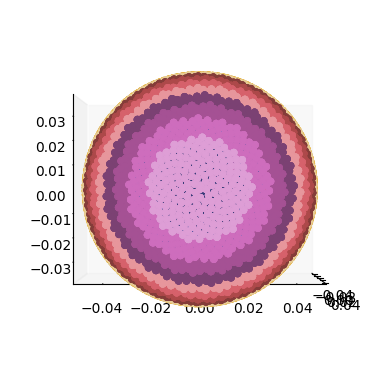

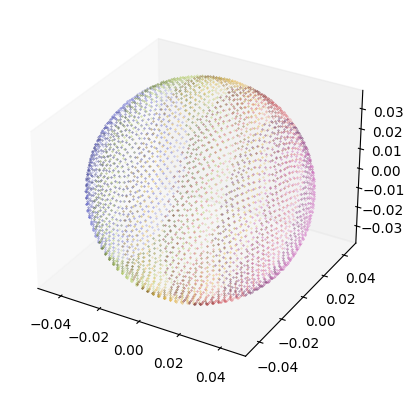

In [7]:
test_transducer_set.plot_transducer_fovs(scale=0.05, view=(0,0))
test_transducer_set.plot_transducer_coords(scale=0.05)

In [8]:
extended_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

In [9]:
simprops = simulation.SimProperties(
                grid_size   = (60e-3,60e-3,60e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [10]:
extended_experiment = experiment.Experiment(
                 simulation_path = 'tomography_net_test_4',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

extended_experiment.save()

[Text(0, 0, '0.064'), Text(0, 256, '0')]

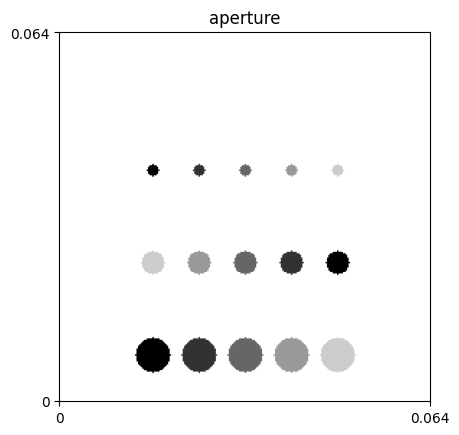

In [11]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])
plt.gca().set_title('aperture')
plt.gca().set_xticks([-1,256])
plt.gca().set_xticklabels(['0','0.064'])
plt.gca().set_yticks([0,256])
plt.gca().set_yticklabels(['0.064','0'])
# plt.savefig('contrast_phantom.png', dpi=300, bbox_inches="tight")

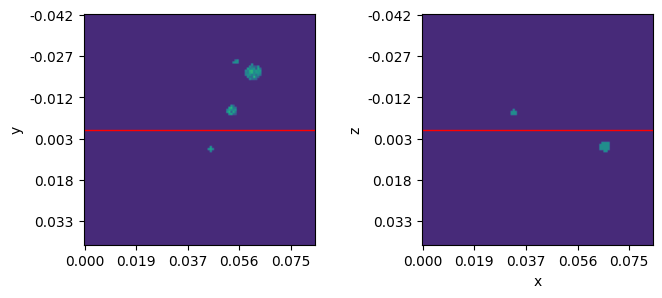

In [12]:
extended_experiment.plot_ray_path(50)

In [13]:
test_experiment = experiment.Experiment.load('tomography_net_test_4')
test_experiment.run(dry=True, dry_fast=True)
test_experiment.run(repeat=True)

dry run of simulation
Fast dry runs only works when all transducers are identical, use dry_fast=False if your transducers differ from each other


100%|██████████| 4096/4096 [00:00<00:00, 1911635.61it/s]

running with 3 workers



preparation for sim    0 completed in  3.62 seconds
preparation for sim    1 completed in  3.92 seconds
simulation             0 completed in  2.84 seconds
simulation             1 completed in  2.86 seconds
preparation for sim    2 completed in  3.94 seconds
preparation for sim   98 completed in  4.13 seconds
preparation for sim    3 completed in  4.18 seconds
simulation             2 completed in  2.62 seconds
preparation for sim   99 completed in  4.48 seconds
simulation            98 completed in  2.59 seconds
simulation             3 completed in  2.81 seconds
preparation for sim    4 completed in  4.19 seconds
simulation            99 completed in  2.70 seconds
preparation for sim  100 completed in  4.12 seconds
simulation             4 completed in  2.77 seconds
preparation for sim    5 completed in  5.22 seconds
preparation for sim  101 completed in  4.73 seconds
simulation           100 completed in  2.70 seconds
preparation for sim    6 completed in  4.15 seconds
simulation  

# Reconstruction

In [3]:
test_experiment = experiment.Experiment.load('tomography_net_test_4')
test_experiment.run(dry=True, dry_fast=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation
Fast dry runs only works when all transducers are identical, use dry_fast=False if your transducers differ from each other


100%|██████████| 4096/4096 [00:00<00:00, 1913338.81it/s]


In [4]:
images1 = test_reconstruction.compound(workers=16, resolution_multiplier=2, combine=False, attenuation_factor=16, volumetric=True, save_intermediates=True)

100%|██████████| 196/196 [00:00<00:00, 3121.21it/s]

running reconstruction on 196 rays


running reconstruction on ray 0
running reconstruction on ray 4
running reconstruction on ray 8
running reconstruction on ray 12
running reconstruction on ray 16
running reconstruction on ray 20
running reconstruction on ray 24
running reconstruction on ray 28
running reconstruction on ray 32
running reconstruction on ray 36
running reconstruction on ray 40
running reconstruction on ray 44
running reconstruction on ray 48
running reconstruction on ray 52
running reconstruction on ray 56
running reconstruction on ray 60
running reconstruction on ray 1
running reconstruction on ray 13
running reconstruction on ray 2
running reconstruction on ray 25
running reconstruction on ray 61
running reconstruction on ray 49
running reconstruction on ray 37
running reconstruction on ray 45
running reconstruction on ray 21
running reconstruction on ray 9
running reconstruction on ray 17
running reconstruction on ray 33
running reconstruction on ray 5
running reconstruction on ray 57
running reconstru

In [9]:
files = glob.glob('tomography_net_test_4/reconstruct/intermediate_image_000*.npz')
images1 = []
for path in tqdm.tqdm(files):
    images1.append(utils.load_array(path))
    # break
images1 = np.array(images1)

image1 = np.sum(images1, axis=0)/len(images1)

100%|██████████| 196/196 [00:00<00:00, 207.31it/s]


In [14]:
utils.save_mrc(image1, 'tomography_net_test_4.mrc')

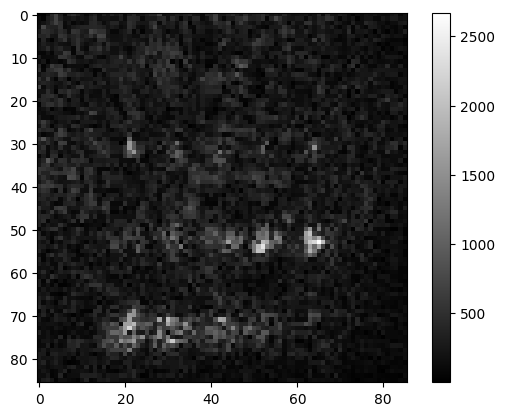

In [22]:
# plt.imshow(images1[180][:,:,images1.shape[-1]//2], cmap='gray', vmin=0, vmax=5000)
plt.imshow(images1[190][:,:,images1.shape[-1]//2], cmap='gray')
plt.colorbar()

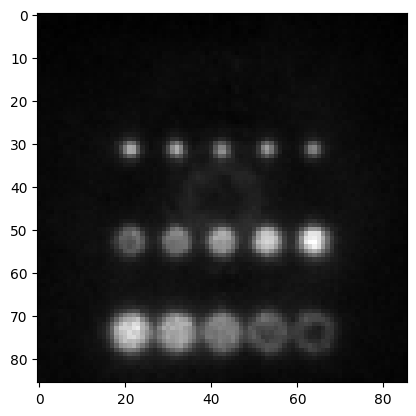

In [11]:
plt.imshow(image1[:,:,image1.shape[2]//2], cmap='gray')

In [ ]:
plt.imshow(images1[100][:,:,images1.shape[-1]//2], cmap='gray')

IndexError: index 100 is out of bounds for axis 0 with size 1

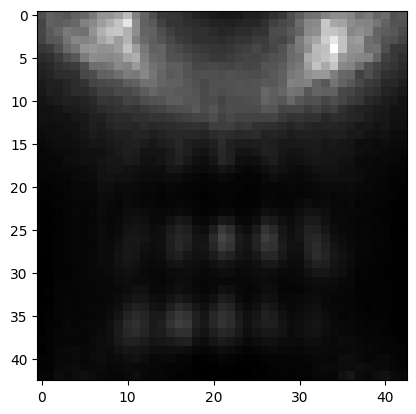

In [ ]:
plt.imshow(image1[:,:,image1.shape[2]//2], cmap='gray')

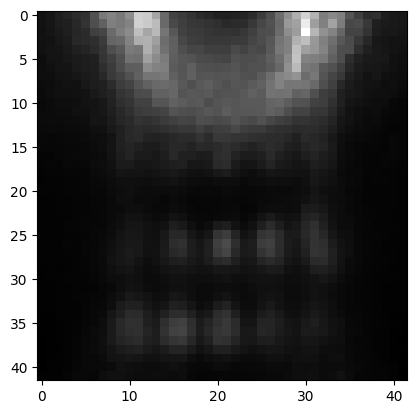

In [ ]:
plt.imshow(image1[:,:,image1.shape[2]//2], cmap='gray')

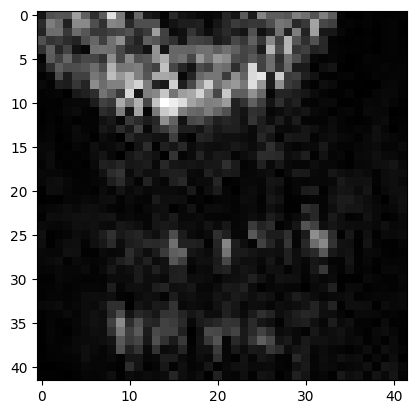

In [ ]:
plt.imshow(images1[9][:,:,images1.shape[-1]//2], cmap='gray')

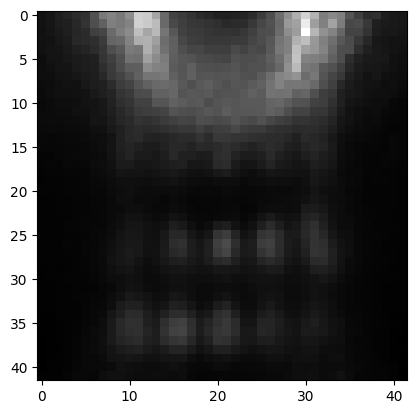

In [ ]:
plt.imshow(image1[:,:,image1.shape[2]//2], cmap='gray')

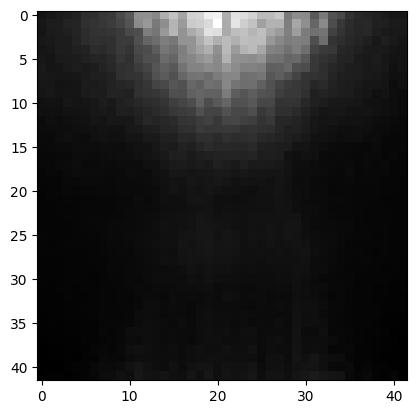

In [ ]:
plt.imshow(image1[:,:,0], cmap='gray')

NameError: name 'sensor_mask' is not defined

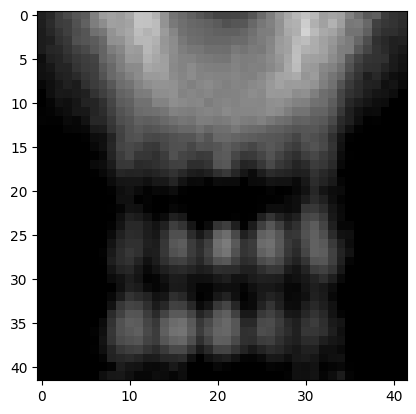

In [ ]:
psf = 20 * np.log10(image1 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()
contour_cmap = plt.cm.get_cmap('plasma')

im = ax.imshow(image, cmap='gray', vmin=-60, vmax=-30)
ax.imshow(sensor_mask, cmap='cool_r', alpha=(sensor_mask>0)*1.0)
CS = ax.contour(image, cmap=contour_cmap, linewidths=0.5, levels = [-90,-85,-80,-75,-70,-65,-60])

ax.set_title('sequential averaged')

# plt.colorbar(im, cax=ax.inset_axes([1.035, 0, 0.04, 1]), label='dB', ticks=[-100,-75,-70,-65,-60,-55,-50,0])
# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_edgecolor()[0]) for pc in CS.collections]
# plt.legend(proxy[::-1], ['','','','','',''][::-1], frameon=False, handlelength=1, handleheight=0.01, fontsize=10, bbox_to_anchor=(1.138, 0.55), labelspacing = 0.33)
# ax.clabel(CS, inline=True, fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
# if overwrite_figures:
#     plt.savefig('sequential_aperture_contrast.png', dpi=300, bbox_inches="tight")

TypeError: Invalid shape (101,) for image data

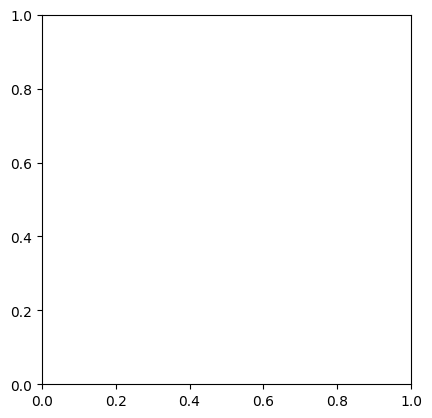

In [ ]:
plt.imshow(np.sum(utils.load_array('tomography_net_test_2/results/signal_000001.npy'),axis = -1))

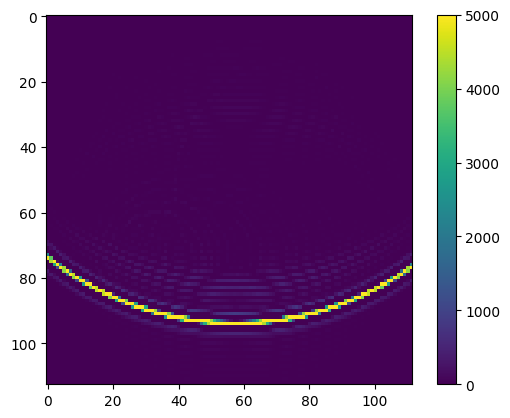

In [ ]:
plt.imshow(utils.load_array('spherical_tomography_test_3d/results/signal_000000.npy')[...,320], vmin=0, vmax=5000)
plt.colorbar()

In [17]:

num_transducers = 1024
transducers = [transducer.Focused(max_frequency=0.5e6,
                                    elements = 1, 
                                    width = 2e-3,
                                    height =  2e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = (0,0),
                                    ray_num = (1,1),
                                    imaging_ndims = 3,
                                    focus_azimuth = float('inf'),
                                    focus_elevation = float('inf'),
                                    source_strength = 1e7,
                                    cycles = 1,
                                    transmit = i%21==0,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [18]:
global_transform = geometry.Transform([np.pi * 0.87,np.pi * -0.05,0],[-0.00,0.005,-0.01], intrinsic=False)
coords, angles = fibonacci_sphere(num_transducers, maxphi=np.pi/2)

for i,(coord,angle) in enumerate(zip(coords, angles)):
    test_transducer_set.assign_pose(i, global_transform * geometry.Transform(angle, global_transform.apply_to_point(coord) * 0.07, intrinsic=False))

In [19]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

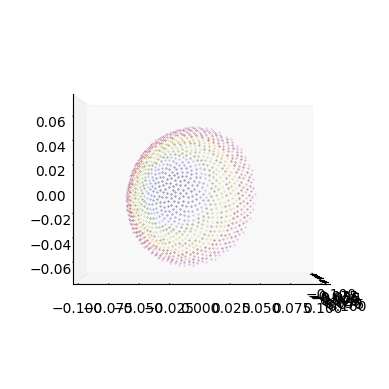

In [20]:
test_transducer_set.plot_transducer_coords(scale = 0.1, view=(0,0))

In [21]:
test_sensor.sensor_coords.shape

(1024, 3)

In [22]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(test_sensor.sensor_coords)
o3d.io.write_point_cloud("sensor_coords.ply", pcd)

True